In [102]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path

realigned_atlas = nib.load('../../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../../Data/pig_2/rfmri files/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0

brain_mask = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

posterior_cingulate_cortex = [131,231,223,123]
posterior_cingulate_cortex_indices = []
posterior_cingulate_cortex_mask = np.ma.masked_where(np.isin(realigned_atlas, posterior_cingulate_cortex, invert=True), realigned_atlas)

prefrontal_cortex = [109,110,209,210]
prefrontal_cortex_indices = []
prefrontal_cortex_mask = np.ma.masked_where(np.isin(realigned_atlas, prefrontal_cortex, invert=True), realigned_atlas)

auditory_cortex = [141,241]
auditory_cortex_indices = []
auditory_cortex_mask = np.ma.masked_where(np.isin(realigned_atlas, auditory_cortex, invert=True), realigned_atlas)

temporal_gyri = [120,121,122,220,221,222]
temporal_gyri_indices = []
temporal_gyri_mask = np.ma.masked_where(np.isin(realigned_atlas, temporal_gyri, invert=True), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(brain_mask), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)
        
assert all_data.shape == (300, 128, 128, 20)
assert masked_data.shape == (300, 128, 128, 20)# basic sanity check

indices = masked_data[1,:,:,:].nonzero()

df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    series_df.loc[triple] = trace
    if isinstance(posterior_cingulate_cortex_mask[x,y,z],np.uint8):
        posterior_cingulate_cortex_indices.extend([i])
    if isinstance(auditory_cortex_mask[x,y,z],np.uint8):
        auditory_cortex_indices.extend([i])
    if isinstance(prefrontal_cortex_mask[x,y,z],np.uint8):
        prefrontal_cortex_indices.extend([i])
    if isinstance(temporal_gyri_mask[x,y,z],np.uint8):
        temporal_gyri_indices.extend([i])

data_block = np.vstack(series_df.values)[..., np.newaxis]


In [103]:
print(len(temporal_gyri_indices))
print(len(posterior_cingulate_cortex_indices))
print(len(auditory_cortex_indices))
print(len(prefrontal_cortex_indices))

279
181
278
485


In [106]:
from keras.models import load_model
m = load_model('e11_model.h5')

m.evaluate(data_block[:1000], data_block[:1000])

1000/1000 [==============================] - 6s     


3764.8019140625001

In [70]:
layer_14 = m.layers[14]
layer_14.get_config()

{'name': 'max_pooling1d_6',
 'padding': 'valid',
 'pool_size': (3,),
 'strides': (3,),
 'trainable': True}

In [71]:
from sklearn import manifold
from time import time

embedding_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[14].output)
embeddings = embedding_model.predict(data_block)
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

print(embeddings.shape)
print(squished_embeddings.shape)

(7155, 25, 8)
(7155, 200)


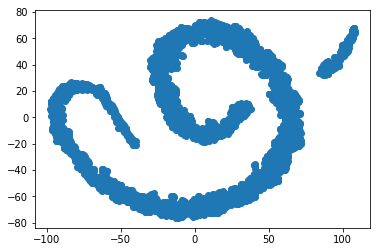

In [107]:
from sklearn import manifold
from time import time


squished_embeddings = np.load('../../Data/numpy-data/e11-embeddings-squished.npy')
tsne = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=50)
tsne_result = tsne.fit_transform(squished_embeddings)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
np.save('../../Data/numpy-data/e11_tsne_50_pig_2_full_dataset.npy', tsne_result) 


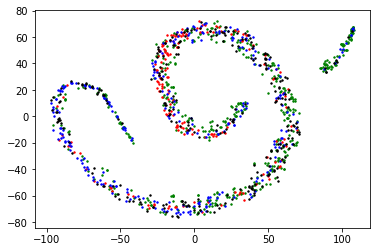

In [108]:
#plt.scatter(tsne_100_result[:, 0], tsne_100_result[:, 1], s=2)

for i in range(len(prefrontal_cortex_indices)):
    plt.scatter(tsne_result[prefrontal_cortex_indices[i],0], tsne_result[prefrontal_cortex_indices[i],1], c='green', s=2)
for i in range(len(posterior_cingulate_cortex_indices)):
    plt.scatter(tsne_result[posterior_cingulate_cortex_indices[i],0], tsne_result[posterior_cingulate_cortex_indices[i],1], c='red', s=2)
for i in range(len(auditory_cortex_indices)):
    plt.scatter(tsne_result[auditory_cortex_indices[i],0], tsne_result[auditory_cortex_indices[i],1], c='blue', s=2)
for i in range(len(temporal_gyri_indices)):
    plt.scatter(tsne_result[temporal_gyri_indices[i],0], tsne_result[temporal_gyri_indices[i],1], c='black', s=2)




plt.savefig('../../Results/tsne_e11/tsne_100_pig_2_full_dataset.png')

 

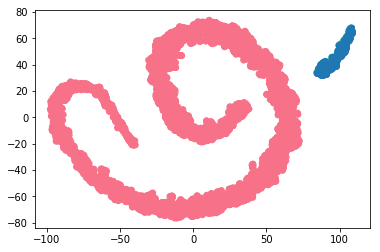

In [115]:
# color (kmeans) and label
from sklearn.cluster import KMeans, DBSCAN

db = DBSCAN(eps=10,min_samples=30)
db.fit_predict(tsne_result)
labels = db.labels_
rgbs = [np.array(c) for c in sns.color_palette("husl", len(np.unique(labels)))]
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors)



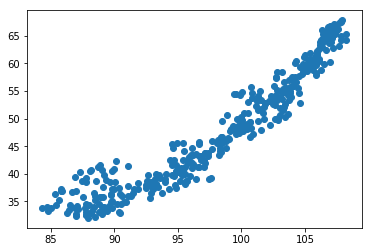

In [116]:

small_island = tsne_result[labels == 1]
plt.scatter(small_island[:,0], small_island[:,1])



In [132]:
slice_i = 0
plt.figure(figsize=(20,10))
small_island_indices = series_df.index[:][labels == 1]

for slice_i in range(realigned_atlas.shape[2]):
    plt.subplot(2, 2, 1)
    plt.imshow(all_data[0, :, :, slice_i], cmap='viridis')

    plt.subplot(2, 2, 2)
    plt.imshow(anatomical[:,:,slice_i], cmap='viridis')
    for p in small_island_indices:
        if p[2] == slice_i:
            pass
            plt.scatter(x=p[0], y=p[1], c='r', s=40)
    
    plt.subplot(2, 2, 3)
    plt.imshow(all_data[0, :,:,slice_i], cmap='viridis')
    for p in small_island_indices:
        if p[2] == slice_i:
            pass
            plt.scatter(x=p[0], y=p[1], c='r', s=40)
            
    plt.savefig('../../Results/Pig 2 TSNE/Experiment 11/slice_' + str(slice_i) + '.png')
    plt.close('all')
    
    

